In [1]:
# Mount Google Drive


from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import zipfile
import os

# Path to your dataset zip in Drive
zip_path = "/content/drive/MyDrive/DATAUNDO/archive.zip"  # change this

# Unzip into /content/data
extract_path = "/content/data"
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped to:", extract_path)


Unzipped to: /content/data


In [3]:
!pip install opencv-python torch torchvision scikit-learn pandas joblib


In [4]:
import os, cv2, csv, joblib
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
from torchvision import datasets, transforms, models
from datetime import datetime, time
import pandas as pd


In [5]:
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1,32,3), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*11*11,128), nn.ReLU(),
            nn.Linear(128,num_classes)
        )
    def forward(self,x): return self.fc(self.conv(x))

device = "cuda" if torch.cuda.is_available() else "cpu"
emotion_model = EmotionCNN(num_classes=7).to(device)


In [6]:
# Make sure you upload FER-2013 dataset to /content/data/FER2013
transform_emotion = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48,48)),
    transforms.ToTensor()
])

train_ds = datasets.ImageFolder("/content/data/train", transform=transform_emotion)
val_ds   = datasets.ImageFolder("/content/data/test", transform=transform_emotion)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_ds, batch_size=64)


In [7]:
import torch.nn as nn
import torch.nn.functional as F

class EmotionCNN(nn.Module):
    def __init__(self, num_classes=7):  # 7 emotions in FER2013
        super(EmotionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

        # Dummy input to calculate flattened size
        dummy = torch.zeros(1, 1, 48, 48)   # (batch, channels, H, W)
        x = self._forward_features(dummy)
        flatten_size = x.view(1, -1).size(1)

        self.fc1 = nn.Linear(flatten_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def _forward_features(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        return x

    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [8]:
# Initialize model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EmotionCNN(num_classes=7).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [10]:
# Training loop
epochs = 20 # you can increase for better accuracy

for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, Accuracy: {acc:.2f}%")


Epoch 1/20, Loss: 0.8452, Accuracy: 68.46%
Epoch 2/20, Loss: 0.7901, Accuracy: 70.34%
Epoch 3/20, Loss: 0.7374, Accuracy: 72.52%
Epoch 4/20, Loss: 0.6918, Accuracy: 74.10%
Epoch 5/20, Loss: 0.6356, Accuracy: 76.10%
Epoch 6/20, Loss: 0.5902, Accuracy: 77.79%
Epoch 7/20, Loss: 0.5555, Accuracy: 78.84%
Epoch 8/20, Loss: 0.5166, Accuracy: 80.42%
Epoch 9/20, Loss: 0.4822, Accuracy: 81.79%
Epoch 10/20, Loss: 0.4527, Accuracy: 82.86%
Epoch 11/20, Loss: 0.4322, Accuracy: 83.60%
Epoch 12/20, Loss: 0.3962, Accuracy: 84.97%
Epoch 13/20, Loss: 0.3802, Accuracy: 85.56%
Epoch 14/20, Loss: 0.3553, Accuracy: 86.44%
Epoch 15/20, Loss: 0.3422, Accuracy: 86.93%
Epoch 16/20, Loss: 0.3284, Accuracy: 87.55%
Epoch 17/20, Loss: 0.3139, Accuracy: 88.19%
Epoch 18/20, Loss: 0.3065, Accuracy: 88.62%
Epoch 19/20, Loss: 0.2864, Accuracy: 88.93%
Epoch 20/20, Loss: 0.2834, Accuracy: 89.40%


In [11]:
import torch


torch.save(model, "model.pth")


torch.save(model.state_dict(), "model_weights.pth")


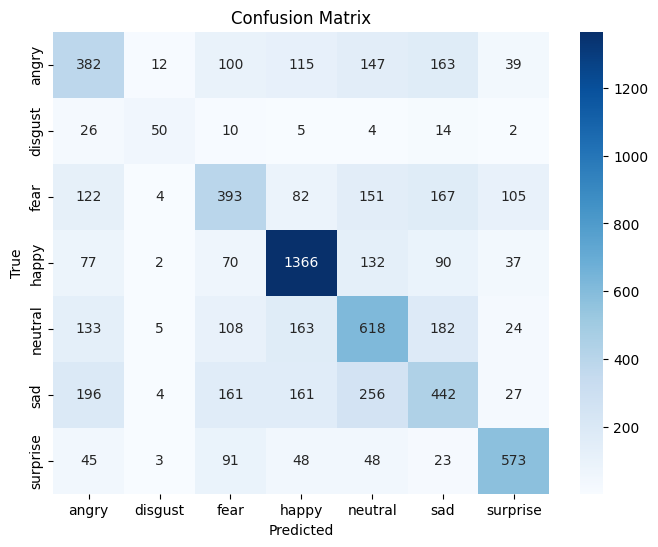


Classification Report:

              precision    recall  f1-score   support

       angry       0.39      0.40      0.39       958
     disgust       0.62      0.45      0.52       111
        fear       0.42      0.38      0.40      1024
       happy       0.70      0.77      0.74      1774
     neutral       0.46      0.50      0.48      1233
         sad       0.41      0.35      0.38      1247
    surprise       0.71      0.69      0.70       831

    accuracy                           0.53      7178
   macro avg       0.53      0.51      0.52      7178
weighted avg       0.53      0.53      0.53      7178



In [15]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_ds.classes,
            yticklabels=train_ds.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=train_ds.classes))


acc = accuracy_score(all_labels, all_preds)


